# Introduction


```py
'''
================================================================
Program ini dibuat untuk menganalisa sentiment pada review yang terdapat di dalam dataset movie.

Data berisi informasi tentang review suatu film. Data hanya memiliki 2 kolom, yaitu kolom text atau review, dan kolom label atau sentiment.

Pengerjaan projek ini keseluruhan dilakukan di google colab, jadi terdapat beberapa proses download.
================================================================
'''
```

## Proses download data

```py
# Download data from kaggle
!kaggle datasets download -d yasserh/imdb-movie-ratings-sentiment-analysis

# Unzip data
!unzip imdb-movie-ratings-sentiment-analysis.zip
```

Data disiapkan melalui proses download dari kaggle

# Import Libraries

In [1]:
# Data loading library
import pandas as pd
import numpy as np
import re

# Data visualization library
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from matplotlib.colors import ListedColormap

# Feature engineering library
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import Embedding

# Model definition and train
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Dense, LSTM, Bidirectional, GRU, Dropout
from tensorflow.keras.models import Sequential

# model evaluation
from sklearn import metrics
from sklearn.metrics import classification_report

# save model
import pickle
import json

# ignore warning
import warnings
warnings.filterwarnings('ignore')

# show all columns
pd.set_option('display.max_columns', None)

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Sebelum memulai pengerjaan projek ini, saya import library yang diperlukan dalam projek ini, adapun beberapa proses download untuk library nltk supaya bisa digunakan.

# Data Loading

## Trimming Data

```py
# Get 10k random samples
df = pd.read_csv('movie.csv').sample(10000)

# Reset index
df.reset_index(drop=True, inplace=True)

# Save 10k randommed data
df.to_csv('movie_trim.csv', index=False)
```

Sebelum melakukan proses untuk load data, saya terlebih dahulu melakukan proses triming dari data. Proses trimming dilakukan supaya komputasi tidak memakan waktu yang sangat lama, hal ini dipertimbangkan karena dalam mengerjakan tugas ini saya melakukannya di google colab. Setelah trimming dilakukan, saya menyimpan csv yang sudah terproses sebagai file baru.

## Load Data

In [2]:
# Load trimmed data
df = pd.read_csv('movie_trim.csv')

In [3]:
# Show data head
df.head()

,text,label
0,When I first heared that there was going to be...,0
1,The story has little to do with Jack London's ...,0
2,Now don't get me wrong. If you need an insight...,0
3,I really wanted to like this film but it barel...,0
4,*May Contain Spoilers* A few weeks after I had...,0


In [4]:
# Show data tail
df.tail()

,text,label
9995,An excellent film depicting the cross currents...,1
9996,When I really began to be interested in movies...,1
9997,I just recently viewed Shame which is directed...,0
9998,"I normally don't comment on movies on IMDB, bu...",1
9999,Once in a while one come across a movie that f...,1


Menampilkan head dan tail pada data.

Label:
- 0 : Negatif review
- 1 : Positif review

In [5]:
# Show summary data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
 1   label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


**Load Data Conclusion:**
- Data sudah ditrim dari 40ribu baris, menjadi 10ribu baris, supaya komputasi tidak memakan waktu lama, karena dalam komputasi epoch pada NLP untuk 10ribu data menghabiskan rata-rata 15menit.
- Data terdapat 2 kolom yang bertipe object dan int64
- Pada label:
    - 0: Negative Review
    - 1: Positive Review

## Cleaning Data

In [6]:
# Copy data raw
df_clean = df.copy()

In [7]:
# cek variabel df_clean
df_clean.head()

,text,label
0,When I first heared that there was going to be...,0
1,The story has little to do with Jack London's ...,0
2,Now don't get me wrong. If you need an insight...,0
3,I really wanted to like this film but it barel...,0
4,*May Contain Spoilers* A few weeks after I had...,0


In [8]:
# Check missing value
df_clean.isna().sum()

text     0
label    0
dtype: int64

In [9]:
# Check duplicate data
df_clean.duplicated().sum()

21

In [10]:
# Handle duplicate data
df_clean.drop_duplicates(inplace=True)

Dataset tidak memiliki missing value, namun terdapat duplikat sebanyak 21 baris. Duplikat selanjutnya akan didrop.

In [11]:
# make function to clean text
def clean_text(text):
    # Remove all symbols and keep only alphanumeric characters and spaces
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    cleaned_text = cleaned_text.strip()
    cleaned_text = cleaned_text.lower()
    return cleaned_text

In [12]:
# apply function
df_clean['text'] = df_clean['text'].apply(clean_text)

In [13]:
# cek
df_clean

,text,label
0,when i first heared that there was going to be...,0
1,the story has little to do with jack londons o...,0
2,now dont get me wrong if you need an insightfu...,0
3,i really wanted to like this film but it barel...,0
4,may contain spoilers a few weeks after i had o...,0
...,...,...
9995,an excellent film depicting the cross currents...,1
9996,when i really began to be interested in movies...,1
9997,i just recently viewed shame which is directed...,0
9998,i normally dont comment on movies on imdb but ...,1


**Cleaning Data Conclusion:**
- Data tidak memiliki missing value
- Data terdapat duplikat sebanyak 21 baris, dilakukan drop untuk handling duplikat data.
- Proses cleaning data meliputi penghapusan spesial karakter, penghapusan white space dan membuat keseluruhan teks menjadi lower case. Hal ini dilakukan supaya stopwords dapat berjalan dengan sempurna.

# Exploratory Data Analysis

In [14]:
# Group label
groupedLabel = df_clean.groupby('label')['label'].value_counts()

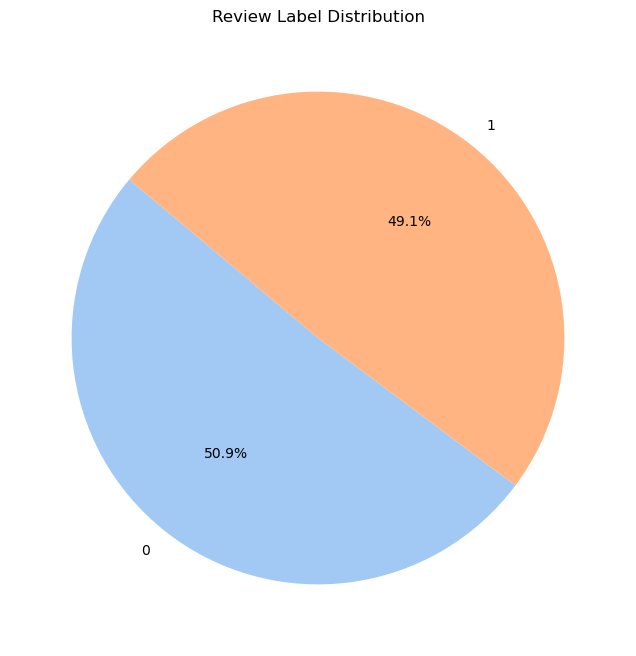

In [17]:
# Group by 'label' and get the count
groupedLabel = df_clean.groupby('label')['label'].value_counts()

# Reset index to make plotting easier
groupedLabel = groupedLabel.reset_index(level=0, name='count')

# Create pie chart
plt.figure(figsize=(8, 8))
colors = sns.color_palette('pastel')[0:len(groupedLabel)]

# Plot pie chart
plt.pie(
    groupedLabel['count'],
    labels=groupedLabel['label'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors
)

# Set title
plt.title('Review Label Distribution')

# Show the plot
plt.show()

Pengecekan distribusi dari label 0 dan 1 memiliki persebaran sebesar:

- 0: 50.8%
- 1: 49.2%

Persebaran tersebut dapat diartikan bahwa target dari dataset sudah balance.

In [16]:
# make var for stopword
df_stopword = set(stopwords.words('english'))
word = df_clean['text'].str.split()

In [17]:
# Apply var stopword in new var clean_word
clean_word = []
for words in word:
    temp = []
    for i in words:
        if(i not in df_stopword):
            temp.append(i)
    clean_word.append(temp)

In [18]:
# Make a new dataframe for wordcloud
df_wordcloud = df_clean.copy()

# Make a new column words
df_wordcloud['words'] = clean_word

# the code below for wordcloud in positive sentiment
word_in_postv = df_wordcloud[df_wordcloud['label']==1]['words']
text_pos = []
for wip in word_in_postv:
    text_pos += wip
con_text_pos = ' '.join(text_pos)

# the code below for wordcloud in negative sentiment
word_in_negtv = df_wordcloud[df_wordcloud['label']==0]['words']
text_neg = []
for win in word_in_negtv:
    text_neg += win
con_text_neg = ' '.join(text_neg)

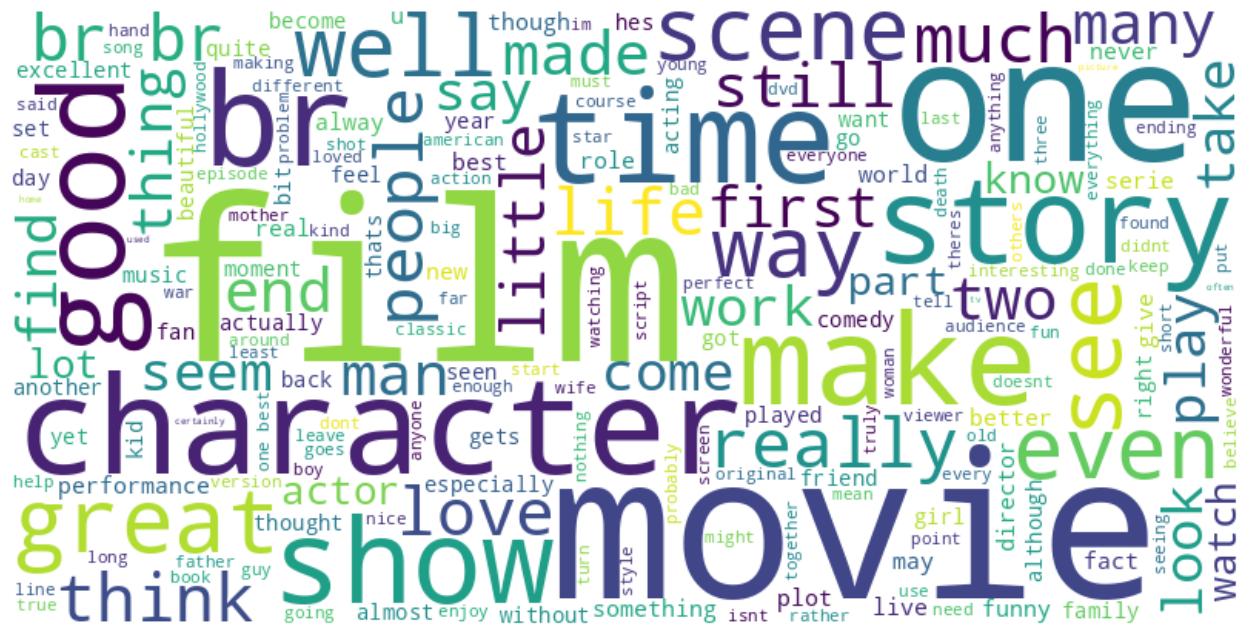

In [19]:
# Wordcloud for positive sentiment
positive_wordcloud = WordCloud(width=800,height=400,background_color='white').generate(con_text_pos)
plt.figure(figsize=(16,8))
plt.imshow(positive_wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

Dari hasil pembuatan grafik wordcloud, wordcloud di atas adalah sebuah kata yang terdapat pada positive review.

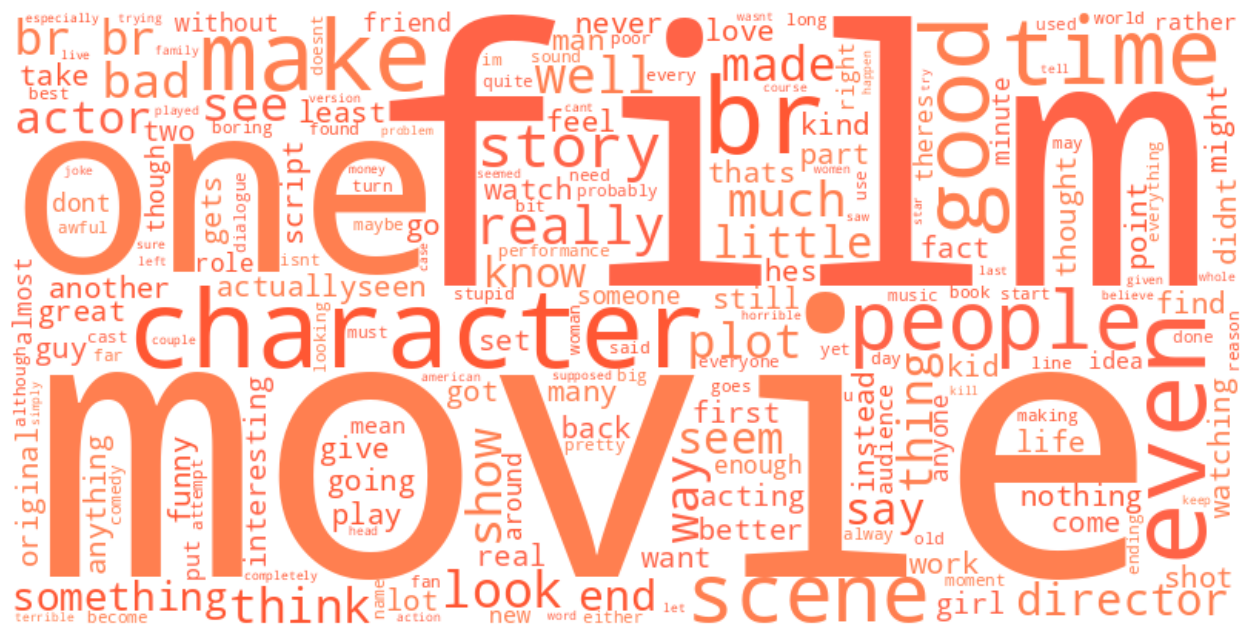

In [20]:

# Define custom red color scheme
red_colors = ['#FF5733', '#FF6347', '#FF7F50']  # Example shades of red
red_cmap = ListedColormap(red_colors)

# Generate word cloud with custom color scheme
negative_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=red_cmap).generate(con_text_neg)

# Display the word cloud using matplotlib
plt.figure(figsize=(16, 8))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Wordcloud di atas adalah isi kata yang terdapat pada negative review

**Kesimpulan EDA**

- Distribusi data antara positif sentiment dengan negatif sentiment sudah balance karena didapatkan bahwa data yang terbagi adalah 50.8% (negative sentiment) vs 49.2% (positive sentiment) dengan demikian persebaran target data sudah termasuk balance.
- Sentiment Distribution:
    - Positive sentiment wordcloud 3 terbesar:
        - film
        - movie
        - one

    - Negative sentiment wordcloud 3 terbesar:
        - film
        - movie
        - one
    
        Jika hanya dilihat dari 3 terbesar untuk setiap sentiment wordcloud, tidak ada perbedaan, namun untuk yang lebih kecilnya memiliki beberapa perbedaan.

# Feature Engineering

## Further Cleaning (Text Preprocessing)

In [21]:
# Define stopword
en_sword = list(set(stopwords.words('english')))
en_sword.append('dont')
en_sword.append('br')
en_sword.append('cant')
en_sword.append('isnt')

# Define lemmatizer
lemmatizer = WordNetLemmatizer()

Kode di atas untuk melakukan text preprocessing yang bertujuan untuk menghapus stopwords dalam Bahasa Inggris, lemmatizer digunakan untuk merubah kata seperti running dan ran menjadi run.

In [22]:
# create a function for text preprocessing

def text_preprocessing(text):
  # case folding
  text = text.lower()

  # mention removal
  text = re.sub("@[a-za-z0-9_]+", " ", text)

  # hashtags removal
  text = re.sub("#[a-za-z0-9_]+", " ", text)

  # newline removal (\n)
  text = re.sub(r"\\n", " ",text)

  # whitespace removal
  text = text.strip()

  # url removal
  text = re.sub(r"http\s+", " ", text)
  text = re.sub(r"www.\s+", " ", text)

  # non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
  text = re.sub("[^a-za-z\s']", " ", text)
  text = re.sub("'", "", text)

  # tokenization
  tokens = word_tokenize(text)

  # stopwords removal
  tokens = [word for word in tokens if word not in en_sword]

  # lemmatizing
  tokens = [lemmatizer.lemmatize(word) for word in tokens]

  # combining tokens
  text = ' '.join(tokens)

  return text

In [23]:
# Apply into new column
df_clean['text_processed'] = df_clean['text'].apply(lambda x: text_preprocessing(x))
df_clean

,text,label,text_processed
0,when i first heared that there was going to be...,0,first heared going world enough video game nin...
1,the story has little to do with jack londons o...,0,story little jack london original novel though...
2,now dont get me wrong if you need an insightfu...,0,get wrong need insightful summary everything w...
3,i really wanted to like this film but it barel...,0,really wanted like film barely eked surprising...
4,may contain spoilers a few weeks after i had o...,0,may contain spoiler week originally wrote revi...
...,...,...,...
9995,an excellent film depicting the cross currents...,1,excellent film depicting cross current life mu...
9996,when i really began to be interested in movies...,1,really began interested movie age eleven big l...
9997,i just recently viewed shame which is directed...,0,recently viewed shame directed ingmar bergman ...
9998,i normally dont comment on movies on imdb but ...,1,normally comment movie imdb case feel like lov...


**Text Preprocessing Conclusion:**

Dalam proses kali ini, ada penggunaan stopwords supaya kata-kata yang terbentuk lebih bersih untuk model train, sehingga model dapat mendapatkan hasil yang cenderung bagus. Proses dalam tahap ini meliputi:
- Penggunaan stopword dan penambahan beberapa stopwords karena ada beberapa hal yang gagal dihapus padahal itu masuk ke dalam stopword.
- Further cleaning proccess, sebelumnya sudah dilakukan proses cleaning, namun untuk lebih memastikan lagi bahwa data sudah bersih maka dilakukan proses cleaning kedua yang menambahkan beberapa syntax, seperti penghapusan format website dan mention.
- Word Tokenization, adalah sebuah proses untuk membuat token pada dataset. Proses ini meliputi:
    - Penghapusan stopwords pada text
    - Lemmatizer, lemmatizer adalah sebuah fungsi yang menggeneralisasi suatu bentuk kata menjadi kata dasar seperti kata kerja yang berbentuk past tense menjadi kata kerja awal sebelum menjadi past tense, sebagai contoh: running, atau ran menjadi run.

## Split Train-Val-Test

In [24]:
# Split target and feature
X = df_clean['text_processed']
y = df_clean['label']

#split train and test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=16)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=16)

In [25]:
# Check shape train, val and test
print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (6386,)
Val Size   :  (1597,)
Test Size  :  (1996,)


Data displit menjadi train-set, val-set, dan test-set dengan pembagian 80% untuk train dan 20% untuk masing-masing val dan test dan dengan random_state supaya pembagian tidak berubah setiap kali kode dijalankan.

## Text Vectorization

In [26]:
# Use CountVectorizer
vectorizer = CountVectorizer()

X_trainvect = vectorizer.fit_transform(X_train)
X_valvect = vectorizer.transform(X_val)
X_testvect = vectorizer.transform(X_test)

In [27]:
# Finding the Number of Vocabs and Max Token Length in One Document
total_vocab = len(vectorizer.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  52112
Maximum Sentence Length :  1430 tokens


In [28]:
# Text Vectorization
text_vectorization = TextVectorization(max_tokens=10_000, # we limit this to get faster train time
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(X_train)

X_trainvect = text_vectorization(X_train)
X_valvect = text_vectorization(X_val)
X_testvect = text_vectorization(X_test)

Pada proses text vectorize, total vocab yang didapatkan adalah 52112, dengan maximum sentence length 1430. Selanjutnya untuk max tokens saya limit di angka 10000 supaya proses komputasi lebih cepat.

In [29]:
# Get 20 first vocab
text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'movie',
 'film',
 'one',
 'like',
 'good',
 'time',
 'character',
 'even',
 'story',
 'would',
 'get',
 'make',
 'see',
 'really',
 'scene',
 'well',
 'much',
 'also']

In [30]:
# Document example
print('Document Example')
print(df_clean.text_processed[0])
print('')

# Result of text vectorization
print('Result of Text Vectorization')
print(text_vectorization([df_clean.text_processed[0]]))
print('vector size: ',text_vectorization([df_clean.text_processed[0]]).shape)

Document Example
first heared going world enough video game nintendo excited finally came one first one rent rented day got whole game game easy gave much hint majour dissapointing sequel goldeneye take advice rent gamebr sure gun gadget cool one get tired watch lazer look like taken right goldeneye exception red color instead blue color poor excuse dart gun horrible stunner stupid grapple hook attach thing yellow blackbr think rare made game instead ea stick game good making like sport game stear clear first person shooter let master work

Result of Text Vectorization
tf.Tensor([[23  1 78 ...  0  0  0]], shape=(1, 1430), dtype=int64)
vector size:  (1, 1430)


**Text Vectorization:**

Text vectorization adalah sebuah proses untuk merubah total vocab yang didapat kedalam bentuk angka, proses ini dilakukan supaya model machine learning dapat memproses kata yang terdapat pada dataset, karena pada dasarnya model hanya dapat membaca angka dan proses ini sangat diperlukan dalam proses NLP untuk menyelesaikan proses komputasi.

## Word Embedding

In [31]:
# Embedding
embedding = Embedding(input_dim=10_000,
                     output_dim = 128,
                     embeddings_initializer='uniform')

Proses ini dilakukan supaya hasil dari text vectorization lebih spesifik dan tidak general, karena pada dasarnya ada beberapa kata yang memiliki artian atau kasta yang sama dengan kondisi dimana kata tersebut diletakkan dalam 1 vector yang sama, seperti King and Queen, secara vectorisasi kata tersebut memiliki arti yang sama sehingga proses ini dilakukan untuk membuat vector menjadi mendekat.

# ANN Training

## Model Definition

Model yang digunakan dalam penyelesaian projek ini adalah model LSTM. 

Kelebihan model ini yaitu:
- Didesain untuk menyelesaikan proses squential atau proses yang harus diselesaikan secara berurut.
- Biasanya lebih akurat dibanding model GRU

Kelemahan Model LSTM:
- Kecenderungan overfit antara train dengan val
- Komputasi yang memakan waktu lebih lama dan menggunakan memory lebih banyak.

## Model Training

In [32]:
# Clear session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Define architecture
model_lstm = Sequential()
model_lstm.add(embedding)
model_lstm.add(Bidirectional(LSTM(16,return_sequences=True,kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm.add(Bidirectional(LSTM(8, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm.add(Dense(1,activation='sigmoid'))

model_lstm.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(),optimizer = 'adam',metrics = ['accuracy'])

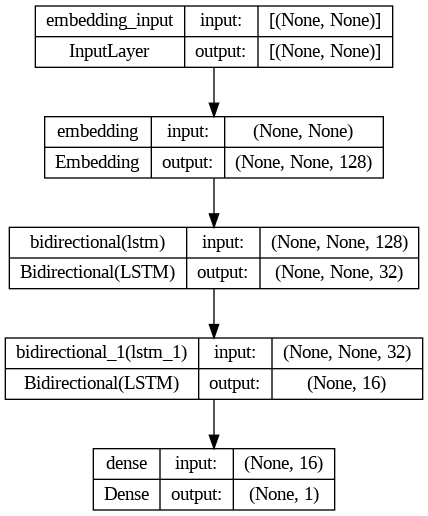

In [33]:
# Plot layers
tf.keras.utils.plot_model(model_lstm, show_shapes=True)

In [34]:
# add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4, restore_best_weights=True)

# Fit model
model_lstm_hist = model_lstm.fit(X_trainvect,y_train,validation_data=(X_valvect,y_val),epochs=25,batch_size=32,callbacks=[early_stopping])

Epoch 1/25
200/200 [==============================] - 51s 221ms/step - loss: 0.1258 - accuracy: 0.7606 - val_loss: 0.1047 - val_accuracy: 0.8341
Epoch 2/25
200/200 [==============================] - 39s 194ms/step - loss: 0.0548 - accuracy: 0.9277 - val_loss: 0.1166 - val_accuracy: 0.8284
Epoch 3/25
200/200 [==============================] - 34s 173ms/step - loss: 0.0258 - accuracy: 0.9695 - val_loss: 0.1607 - val_accuracy: 0.8278
Epoch 4/25
200/200 [==============================] - 33s 168ms/step - loss: 0.0115 - accuracy: 0.9883 - val_loss: 0.2285 - val_accuracy: 0.8009
Epoch 5/25
200/200 [==============================] - 32s 162ms/step - loss: 0.0087 - accuracy: 0.9923 - val_loss: 0.2158 - val_accuracy: 0.8053
Epoch 6/25
200/200 [==============================] - 31s 157ms/step - loss: 0.0050 - accuracy: 0.9955 - val_loss: 0.2617 - val_accuracy: 0.8121
Epoch 7/25
200/200 [==============================] - 31s 157ms/step - loss: 0.0021 - accuracy: 0.9987 - val_loss: 0.3620 - val_ac

Dalam proses training saya pertama mendefinisikan layer yang digunakan untuk training. Karena target adalah binary classification, maka saya menggunakan function sigmoid dan binaryfocalcrossentropy sebagai function metrics scorer.

Setelahnya model layer tersebut difit kedalam data train vect dan data validasi val, dengan penambahan metode callbacks yang diisi dengan early_stopping. Early stopping digunakan untuk membuat epoch berhenti ketika accuracy tidak lagi bertambah dengan patience 4 yang artinya ketika 4 epochs selanjutnya tidak memiliki kenaikan, maka running akan distop.

Pada data di atas hasil didapatkan:
- accuracy: 0.9987
- val_accuracy: 0.7840

Model terindikasi overfit terhadap train set, karena memiliki perbedaan yang jauh dengan val set, selain itu karena model sangat sempurna dalam mempelajari train set, tidak dengan data yang baru yang sebelumnya belum dilihat yaitu val-set ataupun test-set.

Dari hasil accuracy yang paling tinggi adalah 0.9987, sedangkan val_accuracy yang paling tinggi masih ada di nilai 0.8178 dengan accuracy pada val_accuracy tersebut adalah 0.9970 hal ini terjadi karena menggunakan function callbacks yang diisi dengan early_stopping dengan patience=4 dan monitor pada nilai accuracy yang artinya jika dalam 4 epoch kedepan tidak ada penambahan nilai accuracy maka repetisi epoch akan distop di epoch ke-4 setelah nilai accuracy epoch tertinggi didapatkan.

## Model Evaluation

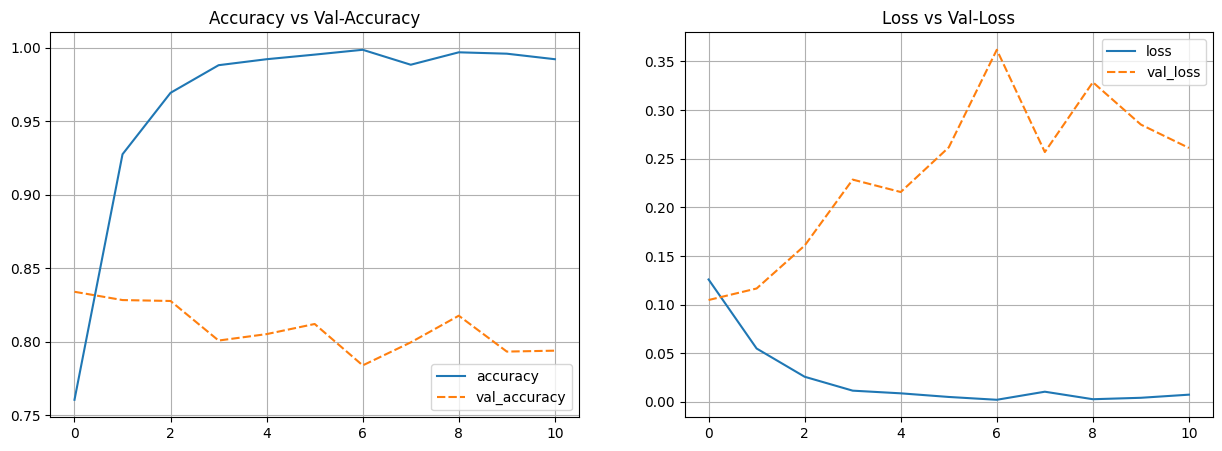

In [35]:
# Plot Training Results LSTM

history_model_lstm = pd.DataFrame(model_lstm_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_model_lstm[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_model_lstm[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [36]:
# Predict
y_predtest_lstm = model_lstm.predict(X_testvect)

63/63 [==============================] - 5s 57ms/step


In [37]:
# proba into label with threshold 0.5
threshold = 0.5
y_predtest_lstm_label = np.where(y_predtest_lstm > threshold, 1, 0)

In [38]:
# Test Loss, Test Accuracy
test_loss_lstm, test_acc_lstm = model_lstm.evaluate(X_testvect, y_test)

# Classification Report
cr_lstm = classification_report(y_test,y_predtest_lstm_label)

# Print
print('LSTM Test Loss : ', test_loss_lstm)
print('LSTM Test Accuracy : ', test_acc_lstm)
print('Classification Report LSTM')
print(cr_lstm)

63/63 [==============================] - 4s 57ms/step - loss: 0.2951 - accuracy: 0.8071
LSTM Test Loss :  0.2950601279735565
LSTM Test Accuracy :  0.8071142435073853
Classification Report LSTM
              precision    recall  f1-score   support

           0       0.90      0.69      0.78       995
           1       0.75      0.92      0.83      1001

    accuracy                           0.81      1996
   macro avg       0.82      0.81      0.80      1996
weighted avg       0.82      0.81      0.80      1996



Model evaluation dilakukan untuk mengevaluasi model antara train-val-test dengan memperhatikan metrics scorernya yaitu accuracy yang terdapat pada f1-score. Sebelumnya sudah didapatkan hasil antara train dan val, selanjutnya proses membandingkan ditambah dengan test set, yaitu hasil yang didapat ketika model sudah dievaluate pada test-set, yaitu:

| Scorer/Data | Train | Val | Test |
| --- | --- | --- | --- |
| Accuracy | 0.9987 | 0.7840 | 0.8100 |

Dari hasil tersebut dapat dipastikan kembali bahwa kelemahan dari model LSTM terbukti yaitu kecenderungan model tersebut dalam overfitting. Proses selanjutnnya adalah improvement.

# ANN Improvement

## Model Definition

Dalam proses ANN improvement, beberapa cara dilakukan untuk membuat supaya model memiliki nilai accuracy yang setidaknya bertambah dibandingkan dengan model sebelum dilakukan improvement. Beberapa hal yang dilakukan pada proses improvement diantaranya adalah:

- Menambahkan layer units pada model:
    - Before:
        - hidden layer 1 16
        - hidden layer 2 8
    - After:
        - hidden layer 1 64
        - hidden layer 2 32
- Menambahkan Dropout sebanyak 0.3 yang artinya 30% Neuron dideaktivasi secara random hal ini dilakukan untuk menanggulangi kecenderungan overfit.

## Model Training

In [52]:
# Clear session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Define Architecture
model_lstm_imp = Sequential()
model_lstm_imp.add(embedding)
model_lstm_imp.add(Bidirectional(LSTM(64,return_sequences=True,kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_imp.add(Dropout(rate = 0.3))
model_lstm_imp.add(Bidirectional(LSTM(32,kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_imp.add(Dropout(rate = 0.3))
model_lstm_imp.add(Dense(1,activation='sigmoid'))

# Compile
model_lstm_imp.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(),
                       optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                       metrics = ['accuracy'])
model_lstm_imp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirection  (None, None, 128)         98816     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 6

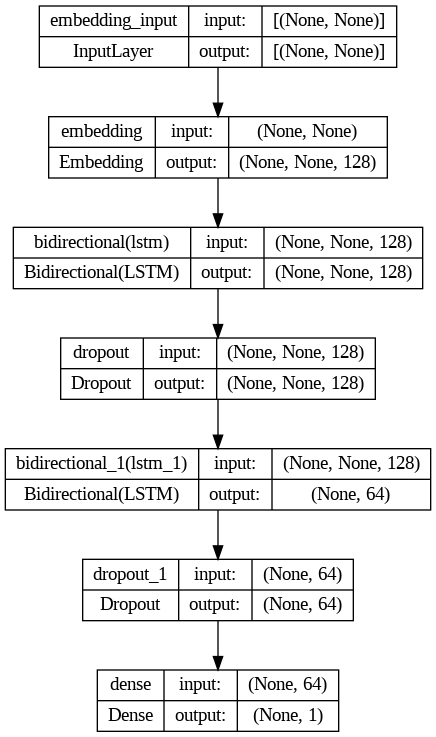

In [53]:
# plot model
tf.keras.utils.plot_model(model_lstm_imp, show_shapes=True)

In [54]:
# Fit Model
model_lstm_imp_hist = model_lstm_imp.fit(X_trainvect,y_train,validation_data=(X_valvect,y_val),epochs=25,batch_size=32,callbacks=[early_stopping])

Epoch 1/25
200/200 [==============================] - 51s 226ms/step - loss: 0.0263 - accuracy: 0.9648 - val_loss: 0.3385 - val_accuracy: 0.7727
Epoch 2/25
200/200 [==============================] - 40s 198ms/step - loss: 0.0038 - accuracy: 0.9958 - val_loss: 0.3413 - val_accuracy: 0.7984
Epoch 3/25
200/200 [==============================] - 36s 180ms/step - loss: 0.0011 - accuracy: 0.9994 - val_loss: 0.3922 - val_accuracy: 0.7827
Epoch 4/25
200/200 [==============================] - 35s 175ms/step - loss: 1.3866e-04 - accuracy: 1.0000 - val_loss: 0.4645 - val_accuracy: 0.8090
Epoch 5/25
200/200 [==============================] - 34s 169ms/step - loss: 5.3148e-05 - accuracy: 1.0000 - val_loss: 0.4983 - val_accuracy: 0.8109
Epoch 6/25
200/200 [==============================] - 33s 165ms/step - loss: 4.1147e-05 - accuracy: 1.0000 - val_loss: 0.5280 - val_accuracy: 0.8115
Epoch 7/25
200/200 [==============================] - 33s 163ms/step - loss: 2.8519e-05 - accuracy: 1.0000 - val_loss:

Setelah dilakukan improvement, model mengalami peningkatan yang cenderung tidak signifikan. Namun begitu hal itu tetap termasuk peningkatan nilai yang artinya proses dalam improve ann model membuahkan sebuah hasil. Peningkatan yang terjadi yaitu pada:

- Accuracy menjadi 1.0000
- Val_accuracy menjadi 0.8090

Pada proses setelah improvement val accuracy tetap memiliki peningkatan dibanding val accuracy terakhir yang memiliki accuracy tertinggi, karena terkena proses early stopping yang dimonitor pada metrics accuracy.

## Model Evaluation

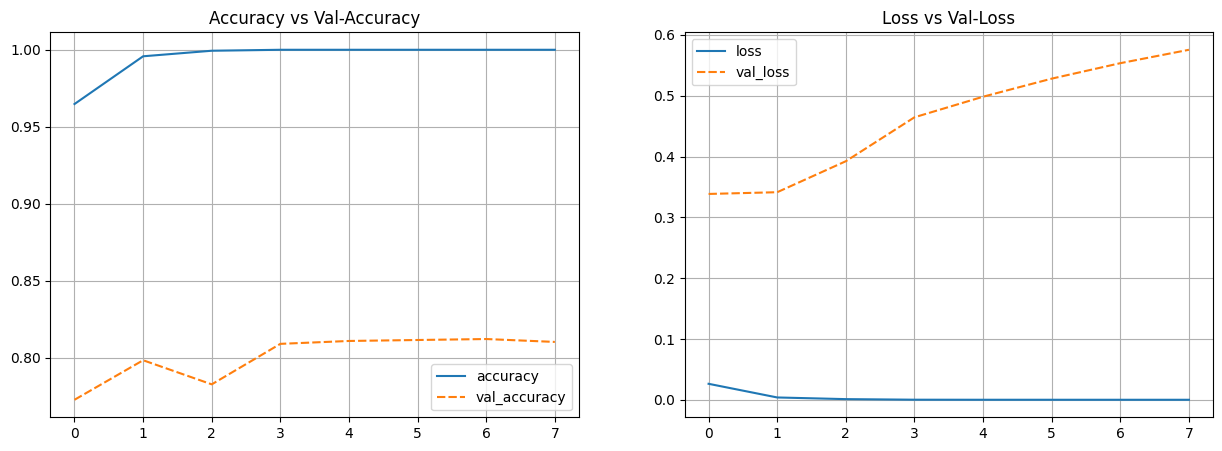

In [55]:
# Plot Training Results

history_model_imp = pd.DataFrame(model_lstm_imp_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_model_imp[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_model_imp[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [56]:
# predict improvement
y_predtest_lstm_imp = model_lstm_imp.predict(X_testvect)
y_predtest_lstm_imp_label = np.where(y_predtest_lstm_imp > threshold, 1, 0)

63/63 [==============================] - 6s 61ms/step


In [57]:
# compare before after
print('lstm_before')
print(classification_report(y_test,y_predtest_lstm_label))
print('lstm_after')
print(classification_report(y_test,y_predtest_lstm_imp_label))

lstm_before
              precision    recall  f1-score   support

           0       0.90      0.69      0.78       995
           1       0.75      0.92      0.83      1001

    accuracy                           0.81      1996
   macro avg       0.82      0.81      0.80      1996
weighted avg       0.82      0.81      0.80      1996

lstm_after
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       995
           1       0.81      0.83      0.82      1001

    accuracy                           0.82      1996
   macro avg       0.82      0.82      0.82      1996
weighted avg       0.82      0.82      0.82      1996



Setelah dilakukan proses penghitungan menggunakan classification report, dapat dilihat bahwa model mengalami sedikit peningkatan pada accuracy f1 score setelah ANN improvement dan setelah proses predict pada test-set. Namun begitu seperti yang sudah diutarakan bahwa model ini masih memiliki kecenderungan overfit.

Berikut table perbandingannya:

| Metrics | Before | After |
| --- | --- | --- |
| Accuracy | 0.9987 | 1.000 |
| Val Accuracy | 0.7840 | 0.8090 |
| Test Accuracy | 0.8100 | 0.8200 |

# Model Saving

In [45]:
# Model Saving
pickle.dump({
    'config':text_vectorization.get_config(),
    'weights':text_vectorization.get_weights()
},open('text_vectorization.pkl','wb'))

model_lstm_imp.save('model.h5')

Setelah didapatkan model terbaik melalui proses ANN Improvement, maka selanjutnya model tersebut yang akan disave yaitu model_lstm_imp dengan format h5.

# Model Inference

Model inference dilakukan pada notebook yang berbeda
>P2G7_Syihabuddin_Ahmad_Inf.ipynb

# Conclusion

Akhirnya setelah semua proses pembuatan model dilakukan, tiba saatnya untuk menarik kesimpulan. Beberapa segment yang dapat diambil kesimpulannya sebagai berikut:

**1. Model Building**

Proses pembentukan model diawal dengan pencarian dataset. Dataset sudah bersih dari missing value dan terdapat sedikit duplikat pada data. Persebaran dataset juga sudah balance, sehingga tidak dilakukan class balancing pada pembentukan model classification.

Kata yang besar pada wordcloud yang memiliki arti bahwa kata tersebutlah yang sering muncul di antara review positive dan negative memiliki kesamaan, namun jika dilihat dari kata yang kecil, di antara keduanya tentu memiliki perbedaan.

Feature engineering yang dilakukan adalah proses pembersihan teks supaya dapat dilakukan proses selanjutnya sehingga mesin dapat membaca suatu kata dengan mengimplementasikan metode TextVectorization dan Embedding, hal ini dilakukan setelah proses split train-val-test.

ANN Training, pada tahap ini saya melakukan percobaan awalnya terhadap GRU dan LSTM, GRU cenderung memiliki kecepatan komputasi yang cepat namun tidak memiliki performa yang bagus jika dibandingkan dengan LSTM, namun setiap kali percobaan untuk running ulang, terkadang GRU lebih baik accuracy f1-scorenya jika dibandingkan dengan LSTM, namun secara keseluruhan lebih sering LSTM yang memiliki nilai accuracy yang bagus, sehingga selanjutnya saya memilih untuk menggunakan 1 model saja yaitu LSTM, karena setiap kali kode dirunning, hasil tidak pernah sama, namun rata-rata accuracy terdapat pada 82%.

Setelah model LSTM dipilih selanjutnya dilakukan proses ANN Improvement, disini dilakukan dengan menambahkan dropout dan layer unit. Pada tahap ini model mengalami peningkatan accuracy sebesar 1%.

Model setelah improvement adalah model yang disimpan, karena model tersebut mengalami peningkatan walaupun tidak signifikan.

**2. Business Insight**

- Secara keseluruhan dari 10ribu sample data yang ditarik antara positive review dengan negative review sudah memiliki kecenderungan yang seimbang.
- Adanya hubungan terhadap psotive review dengan kata 'film', 'movie', 'one','character','story','show','good'

**3. Business Recommendation**

Dalam dunia perfilman, semakin banyak rating yang diperoleh cenderung memiliki peningkatan rata-rata rating, dan dengan meningkatnya rata-rata rating tentu akan menambah positive review terhadap movie, ada pun juga review positive yang berbentuk kritikan namun membangun. Maka dari itu:
- Iklankan film yang sudah dibuat, sehingga dapat reach yang lebih banyak, untuk mendapatkan review dari segmen yang berbeda.
- Buat film dengan mempertimbangkan character, story, dan show, karena 3 hal ini termasuk kata yang memiliki bentuk besar dalam positive review.
- Perhatikan juga plot dalam pembuatan film, karena plot memiliki positive dan negative review, namun lebih besar pada negative review. Seperti hindari plot yang terkesan membosankan.
- Selain itu, mungkin bisa dengan research dlu antara apa yang sedang tren dikalangan penonton, jika ingin mendapatkan rating dan review yang cepat, bisa dengan melakukan pembuatan film dengan genre yang banyak diminati. Namun banyaknya peminat suatu genre dapat menghasilkan challenge sendiri yang berupa pembandingan movie a dan b dengan genre yang sama, yang dapat menjadi bumerang jika tujuannya adalah mendapatkan review positive.

**4. Model Improvement**

Terakhir adalah hal yang bisa diimprove dari model.
- Bisa dengan menggunakan keseluruhan data sehingga model bisa lebih akurat.
    Disini saya tidak menggunakan keseluruhan data karena pengerjaan dilakukan di google colab yang terbatas resource.
- Explore parameter lebih lanjut, mungkin dengan menambahkan hidden layer dan sebagainya. Sehingga dapat menghasilkan model yang memiliki perbedaan lebih signifikan antara before dan afternya.
- Mungkin jika ada model selain GRU dan LSTM bisa coba untuk digunakan model yang lain, atau explore lebih lanjut pada model GRU dan LSTM.
- Coba implementasikan transfer learning pada penyelesaian projek, karena transfer learning memiliki kecenderungan yang bestfit, karena model didapat dari model yang sudah ditrain dan memiliki jutaan atau puluhan juta parameter, challengenya kita perlu membaca dokumentasi dan menyesuaikan data preprocessing dengan dokumentasi dari suatu model yang dipilih dalam transfer learning.